# Degredation of simulated plant

We simulate a PV power plant, add some simple artificial degredation and use rdtools to then find that degredation.

In [1]:
import rdtools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns;sns.set_style("whitegrid")

import pvlib

## Weather

Use simulated weather data from www.renewables.ninja

In [2]:
def _read(n):
    df = pd.read_csv(n, comment="#")
    df = df.set_index(pd.DatetimeIndex(df.time))
    df = df.drop(["time", "local_time"], axis=1)
    return df

 
df =_read("data/ninja_weather_40.5278_19.5263_uncorrected.csv").join(
    _read("data/ninja_wind_40.5278_19.5263_corrected.csv")).drop(
    "electricity", axis=1).rename(columns={
    "temperature" : "Tamb", "radiation_surface": "ghi"
})


location = pvlib.location.Location(
    40.5278, 19.5263, 'Europe/Tirane', 700, 'Tirane')
df.head()

,Tamb,ghi,wind_speed
time,,,
2019-01-01 00:00:00,5.809,0.0,7.812
2019-01-01 01:00:00,5.723,0.0,7.719
2019-01-01 02:00:00,5.646,0.0,7.679
2019-01-01 03:00:00,5.371,0.0,7.777
2019-01-01 04:00:00,5.121,0.0,7.888


In [3]:
df = df.join(np.radians(
    location.get_solarposition(df.index)[["zenith"]]))
df.head()

,Tamb,ghi,wind_speed,zenith
time,,,,
2019-01-01 00:00:00,5.809,0.0,7.812,2.730673
2019-01-01 01:00:00,5.723,0.0,7.719,2.560895
2019-01-01 02:00:00,5.646,0.0,7.679,2.368539
2019-01-01 03:00:00,5.371,0.0,7.777,2.170073
2019-01-01 04:00:00,5.121,0.0,7.888,1.972732


In [4]:
dni = pvlib.irradiance.dirint(
    df.ghi,
    location.get_solarposition(df.index).apparent_zenith,
    df.index)

df = df.join(dni).join(
    pd.Series(df.ghi - np.cos(df.zenith) * dni, name="dhi"))
df.head()

,Tamb,ghi,wind_speed,zenith,dni,dhi
time,,,,,,
2019-01-01 00:00:00,5.809,0.0,7.812,2.730673,NaN,NaN
2019-01-01 01:00:00,5.723,0.0,7.719,2.560895,NaN,NaN
2019-01-01 02:00:00,5.646,0.0,7.679,2.368539,NaN,NaN
2019-01-01 03:00:00,5.371,0.0,7.777,2.170073,NaN,NaN
2019-01-01 04:00:00,5.121,0.0,7.888,1.972732,NaN,NaN


## Simulate plant

Simulate a simple 20° tilt, south oriented plant using the simulated weather data.

In [5]:
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules[sandia_modules.columns[5]]
inverter = cec_inverters[cec_inverters.columns[4]]


system = pvlib.pvsystem.PVSystem(
    surface_tilt=20, surface_azimuth=180,
    module_parameters=module,
    inverter_parameters=inverter)
system

PVSystem:
  name: None
  surface_tilt: 20
  surface_azimuth: 180
  module: None
  inverter: None
  albedo: 0.25
  racking_model: None
  module_type: None
  temperature_model_parameters: {}

In [6]:
mc = pvlib.modelchain.ModelChain(system, location)
mc.run_model(weather=df)

/home/dutchman/miniconda3/lib/python3.9/site-packages/pvlib/pvsystem.py:478: pvlibDeprecationWarning: temperature_model_parameters, racking_model, and module_type are not specified. Reverting to deprecated default: SAPM cell temperature model parameters for a glass/glass module in open racking. In v0.9, temperature_model_parameters or a valid combination of racking_model and module_type will be required.
  warnings.warn(


ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

Text(0, 0.5, 'AC Power [W]')

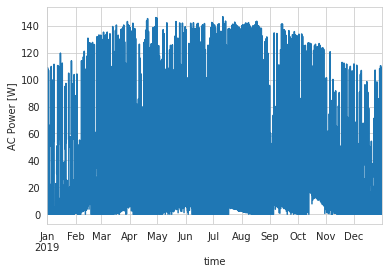

In [7]:
mc.ac.plot()
plt.ylabel("AC Power [W]")

## Create multiple years of data

Repeat the same year of simulated data but reducing the AC output every year by ~1%.

In [41]:
df2 = df.copy()
df2 = df2.join(pd.Series(mc.ac, name="power_ac"))
df2 = df2.join(pd.Series(mc.total_irrad.poa_global, name="poa"))


def _gen_year(year, factor):
    retval = df2.set_index(
        pd.date_range(year, freq="1h", periods=len(df2)))
    retval["power_ac"] *= factor
    return retval

_rand = lambda : (np.random.random() -.5) / 10

years = []
years.append(_gen_year("2015-01-01", 1.0 - 1 * 0.01 + _rand()))
years.append(_gen_year("2016-01-01", 1.0 - 2 * 0.01 + _rand()))
years.append(_gen_year("2017-01-01", 1.0 - 3 * 0.01 + _rand()))
years.append(_gen_year("2018-01-01", 1.0 - 4 * 0.01 + _rand()))
years.append(_gen_year("2019-01-01", 1.0 - 5 * 0.01 + _rand()))
years.append(_gen_year("2020-01-01", 1.0 - 6 * 0.01 + _rand()))

df2 = pd.concat(years)

df2.head()

,Tamb,ghi,wind_speed,zenith,dni,dhi,power_ac,poa
2015-01-01 00:00:00,5.809,0.0,7.812,2.730673,NaN,NaN,NaN,NaN
2015-01-01 01:00:00,5.723,0.0,7.719,2.560895,NaN,NaN,NaN,NaN
2015-01-01 02:00:00,5.646,0.0,7.679,2.368539,NaN,NaN,NaN,NaN
2015-01-01 03:00:00,5.371,0.0,7.777,2.170073,NaN,NaN,NaN,NaN
2015-01-01 04:00:00,5.121,0.0,7.888,1.972732,NaN,NaN,NaN,NaN


## Degredation


Here we simply run the code from this rdtools tutorial:
https://rdtools.readthedocs.io/en/stable/examples/degradation_and_soiling_example_pvdaq_4.html#0:-Import-and-preliminary-calculations

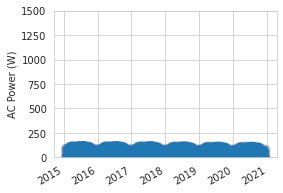

In [9]:
# Specify the Metadata
meta = {"latitude": location.latitude,
        "longitude": location.longitude,
        "timezone": 'Etc/GMT+7',
        "gamma_pdc": -0.005,
        "azimuth": 180,
        "tilt": 20,
        "power_dc_rated": 1000.0,
        "temp_model_params":
        pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']}

loc = pvlib.location.Location(meta['latitude'], meta['longitude'], tz = meta['timezone'])

# There is some missing data, but we can infer the frequency from
# the first several data points
freq = pd.infer_freq(df2.index[:10])

# Then set the frequency of the dataframe.
# It is recommended not to up- or downsample at this step
# but rather to use interpolate to regularize the time series
# to its dominant or underlying frequency. Interpolate is not
# generally recommended for downsampling in this application.
df2 = rdtools.interpolate(df2, freq)

# Calculate cell temperature
df2['Tcell'] = pvlib.temperature.sapm_cell(
    df2.poa, df2.Tamb, df2.wind_speed, **meta['temp_model_params'])

# plot the AC power time series
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(df2.index, df2.power_ac, 'o', alpha=0.01)
ax.set_ylim(0,1500)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (W)');

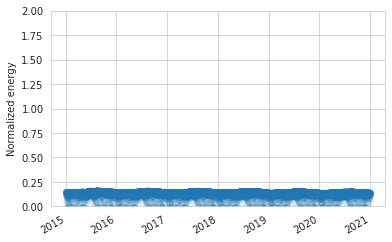

In [10]:
# Calculate the expected power with a simple PVWatts DC model
modeled_power = pvlib.pvsystem.pvwatts_dc(
    df2['poa'], df2['Tcell'],
    meta['power_dc_rated'],  meta['gamma_pdc'], 25.0 )

# Calculate the normalization, the function also returns the relevant insolation for
# each point in the normalized PV energy timeseries
normalized, insolation = rdtools.normalize_with_expected_power(
    df2['power_ac'], modeled_power, df2['poa'])

df2['normalized'] = normalized
df2['insolation'] = insolation

# Plot the normalized power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

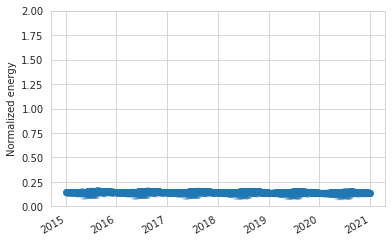

In [11]:
# Calculate a collection of boolean masks that can be used
# to filter the time series
normalized_mask = rdtools.normalized_filter(df2['normalized'])
poa_mask = rdtools.poa_filter(df2['poa'])
tcell_mask = rdtools.tcell_filter(df2['Tcell'])
# Note: This clipping mask may be disabled when you are sure the system is not
# experiencing clipping due to high DC/AC ratio
clip_mask = rdtools.clip_filter(df2['power_ac'])

# filter the time series and keep only the columns needed for the
# remaining steps
filtered = df2[normalized_mask & poa_mask & tcell_mask & clip_mask]
filtered = filtered[['insolation', 'normalized']]

fig, ax = plt.subplots()
ax.plot(filtered.index, filtered.normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

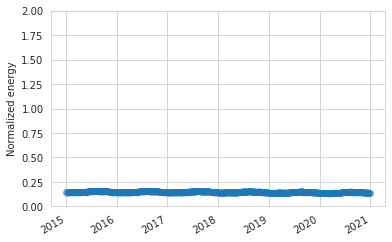

In [12]:
daily = rdtools.aggregation_insol(
    filtered.normalized, filtered.insolation, frequency = 'D')

fig, ax = plt.subplots()
ax.plot(daily.index, daily, 'o', alpha = 0.1)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

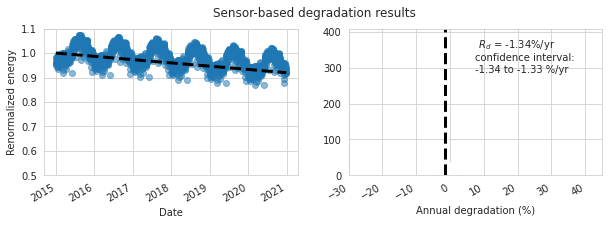

In [13]:
# Calculate the degradation rate using the YoY method
yoy_rd, yoy_ci, yoy_info = rdtools.degradation_year_on_year(
    daily, confidence_level=68.2)
# Note the default confidence_level of 68.2 is appropriate if you would like to
# report a confidence interval analogous to the standard deviation of a normal
# distribution. The size of the confidence interval is adjustable by setting the
# confidence_level variable.

# Visualize the results

degradation_fig = rdtools.degradation_summary_plots(
    yoy_rd, yoy_ci, yoy_info, daily,
    summary_title='Sensor-based degradation results',
    scatter_ymin=0.5, scatter_ymax=1.1,
    hist_xmin=-30, hist_xmax=45, bins=100
)